In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import igraph as ig
import shapely
from shapely.geometry import Point
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import contextily as cx
from pathlib import Path

# Add project root to path
sys.path.append(str(Path().resolve().parent))

from src.simplify import *


In [14]:
BASE_DIR = Path.cwd().parent  
data_path = BASE_DIR / "input_files"
figure_path = BASE_DIR / "figures"

In [15]:
# =============================================================================
# 1. Load network and create graph
# =============================================================================
base_network = gpd.read_parquet(data_path / "base_network_SRB_basins.parquet")

edges = base_network.reindex(['from_id','to_id'] + [x for x in list(base_network.columns) if x not in ['from_id','to_id']], axis=1)
graph = ig.Graph.TupleList(edges.itertuples(index=False), edge_attrs=list(edges.columns)[2:], directed=True)
graph = graph.connected_components().giant()
edges = edges[edges['id'].isin(graph.es['id'])]

In [16]:
# =============================================================================
# 2. Load agricultural data
# =============================================================================
Path_AgriFile = data_path / "1_agriculture_2023_serbia_NEW_FINAL_26092025.xlsm"
DataFrame_Agri = pd.read_excel(Path_AgriFile)

Clean_DataFrame_Agri = DataFrame_Agri.dropna(subset=["latitude", "longitude", "Utilized agricultural land (UAL)"])

geometry = [Point(xy) for xy in zip(Clean_DataFrame_Agri["longitude"], Clean_DataFrame_Agri["latitude"])]

df_agri = gpd.GeoDataFrame(
    Clean_DataFrame_Agri[["Utilized agricultural land (UAL)"]].rename(columns={"Utilized agricultural land (UAL)": "UAL"}),
    geometry=geometry,
    crs="EPSG:4326"
)


In [17]:
# =============================================================================
# 3. Create nodes from edges for spatial matching
# =============================================================================
vertex_lookup = dict(zip(pd.DataFrame(graph.vs['name'])[0], pd.DataFrame(graph.vs['name']).index))

tqdm.pandas()
from_id_geom = edges.geometry.progress_apply(lambda x: shapely.Point(x.coords[0]))
to_id_geom = edges.geometry.progress_apply(lambda x: shapely.Point(x.coords[-1]))

from_dict = dict(zip(edges['from_id'], from_id_geom))
to_dict = dict(zip(edges['to_id'], to_id_geom))

nodes = pd.concat([
    pd.DataFrame.from_dict(to_dict, orient='index', columns=['geometry']),
    pd.DataFrame.from_dict(from_dict, orient='index', columns=['geometry'])
]).drop_duplicates()

nodes['vertex_id'] = nodes.apply(lambda x: vertex_lookup[x.name], axis=1)
nodes = nodes.reset_index()

nodes_sindex = shapely.STRtree(nodes.geometry)

# =============================================================================
# 4. Map agricultural locations to nearest network nodes
# =============================================================================
df_agri['vertex_id'] = df_agri.geometry.progress_apply(
    lambda x: nodes.iloc[nodes_sindex.nearest(x)].vertex_id
).values

# =============================================================================
# 5. Load sinks (borders, ports, rail)
# =============================================================================
path_to_Sinks = data_path / "Borders_Ports_Rail_geocoded.xlsx"

Sinks = pd.read_excel(path_to_Sinks)
Sinks = Sinks.rename(columns={"LON": "Longitude", "LAT": "Latitude", "TYPE OF\nTRAFFIC": "type"})
Sinks['geometry'] = Sinks.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
Sinks['vertex_id'] = Sinks.geometry.apply(lambda x: nodes.iloc[nodes_sindex.nearest(x)].vertex_id).values

# Split by type
Sinks_road = Sinks[Sinks['type'] == 'road']
Sinks_port = Sinks[Sinks['type'] == 'port']
Sinks_rail = Sinks[Sinks['type'] == 'rail']

print(f"Road border crossings: {len(Sinks_road)}")
print(f"Ports: {len(Sinks_port)}")
print(f"Rail terminals: {len(Sinks_rail)}")



100%|██████████| 4621/4621 [00:00<00:00, 16163.58it/s]

Road border crossings: 23
Ports: 12
Rail terminals: 61


In [18]:
# =============================================================================
# 6. Calculate OD matrices by sink type
# =============================================================================
agri_vertices = df_agri['vertex_id'].unique()

def calculate_access_times(graph, origin_vertices, sink_df, sink_name):
    """Calculate average access time from origins to sinks"""
    sink_vertices = sink_df['vertex_id'].unique()
    
    OD_matrix = np.array(graph.distances(
        source=origin_vertices,
        target=sink_vertices,
        weights='fft'
    ))
    OD_matrix[np.isinf(OD_matrix)] = 12
    
    avg_time = np.mean(OD_matrix, axis=1)
    vertex_to_avg = dict(zip(origin_vertices, avg_time))
    
    print(f"\n{sink_name}: {len(sink_vertices)} destinations, global avg = {np.mean(OD_matrix):.2f} hours")
    
    return vertex_to_avg, OD_matrix

# Calculate for each sink type
road_access, OD_road = calculate_access_times(graph, agri_vertices, Sinks_road, "Road borders")
port_access, OD_port = calculate_access_times(graph, agri_vertices, Sinks_port, "Ports")
rail_access, OD_rail = calculate_access_times(graph, agri_vertices, Sinks_rail, "Rail terminals")

# Also calculate combined (all sinks)
all_access, OD_all = calculate_access_times(graph, agri_vertices, Sinks, "All sinks combined")

# Map back to df_agri
df_agri['avg_access_road'] = df_agri['vertex_id'].map(road_access)
df_agri['avg_access_port'] = df_agri['vertex_id'].map(port_access)
df_agri['avg_access_rail'] = df_agri['vertex_id'].map(rail_access)
df_agri['avg_access_all'] = df_agri['vertex_id'].map(all_access)




Road borders: 23 destinations, global avg = 4.70 hours

Ports: 12 destinations, global avg = 4.15 hours

Rail terminals: 60 destinations, global avg = 3.53 hours

All sinks combined: 95 destinations, global avg = 3.89 hours


In [19]:
def get_distance_to_nearest_facility(df_population, Sink, graph):
    """
    Optimized version using bulk distance matrix calculation with duplicate vertex_id handling
    """
    # Initialize new columns
    df_population = df_population.copy()
    df_population['closest_sink_vertex_id'] = None
    df_population['closest_sink_osm_id'] = None
    df_population['closest_sink_total_fft'] = None
    
    # Get unique vertex IDs for both population and sinks
    unique_pop_vertex_ids = df_population['vertex_id'].unique()
    unique_sink_vertex_ids = Sink['vertex_id'].unique()
    
    # Create mapping from unique sink vertex_ids back to original sink data
    sink_lookup = {}
    for _, row in Sink.iterrows():
        sink_lookup[row['vertex_id']] = row['N°']
    
    # Calculate distance matrix once for unique vertices only
    distance_matrix = np.array(graph.distances(
        source=unique_pop_vertex_ids,
        target=unique_sink_vertex_ids, 
        weights='fft'
    ))
    
    # Create lookup dictionary: vertex_id -> (closest_sink_vertex_id, closest_sink_osm_id, min_distance)
    vertex_to_closest_sink = {}
    
    for i, pop_vertex_id in enumerate(unique_pop_vertex_ids):
        # Get distances from this population point to all unique sinks
        distances_to_sinks = distance_matrix[i, :]
        
        # Find the index of the minimum distance
        min_sink_idx = np.argmin(distances_to_sinks)
        min_distance = distances_to_sinks[min_sink_idx]
        
        # Handle infinite distances (no path found)
        if np.isinf(min_distance):
            vertex_to_closest_sink[pop_vertex_id] = (None, None, float('inf'))
        else:
            closest_sink_vertex_id = unique_sink_vertex_ids[min_sink_idx]
            closest_sink_osm_id = sink_lookup[closest_sink_vertex_id]
            vertex_to_closest_sink[pop_vertex_id] = (
                closest_sink_vertex_id,
                closest_sink_osm_id, 
                min_distance
            )
    
    # Map results back to all population points (including duplicates)
    for idx, row in df_population.iterrows():
        vertex_id = row['vertex_id']
        closest_sink_vertex_id, closest_sink_osm_id, closest_sink_total_fft = vertex_to_closest_sink[vertex_id]
        
        df_population.at[idx, 'closest_sink_vertex_id'] = closest_sink_vertex_id
        df_population.at[idx, 'closest_sink_osm_id'] = closest_sink_osm_id
        df_population.at[idx, 'closest_sink_total_fft'] = closest_sink_total_fft
    
    return df_population

In [20]:
%%time
df_agri['nearest_access_road'] = get_distance_to_nearest_facility(df_agri, Sinks_road, graph)['closest_sink_total_fft']
df_agri['nearest_access_port'] = get_distance_to_nearest_facility(df_agri, Sinks_port, graph)['closest_sink_total_fft']
df_agri['nearest_access_rail'] = get_distance_to_nearest_facility(df_agri, Sinks_rail, graph)['closest_sink_total_fft']

CPU times: total: 13min 49s
Wall time: 14min 17s


In [21]:
# =============================================================================
# 7. Summary statistics
# =============================================================================
print("\n" + "="*60)
print("AGRICULTURAL ACCESSIBILITY SUMMARY")
print("="*60)

print(f"\nNumber of agricultural locations: {len(df_agri)}")
print(f"Total UAL (ha): {df_agri['UAL'].sum():,.0f}")

for col, label in [('avg_access_road', 'Road Borders'), 
                   ('avg_access_port', 'Ports'), 
                   ('avg_access_rail', 'Rail Terminals'),
                   ('avg_access_all', 'All Combined')]:
    print(f"\n--- {label} ---")
    print(f"  Mean:   {df_agri[col].mean():.2f} hours")
    print(f"  Median: {df_agri[col].median():.2f} hours")
    print(f"  Std:    {df_agri[col].std():.2f} hours")
    print(f"  Min:    {df_agri[col].min():.2f} hours")
    print(f"  Max:    {df_agri[col].max():.2f} hours")
    print(f"  P10:    {df_agri[col].quantile(0.10):.2f} hours")
    print(f"  P90:    {df_agri[col].quantile(0.90):.2f} hours")

# Category distribution for each type
bins = [0, 0.5, 1, 2, 5, float('inf')]
labels_cat = ['0-0.5h', '0.5-1h', '1-2h', '2-5h', '5h+']

print("\n--- Distribution by Access Time Category ---")
for col, label in [('avg_access_road', 'Road'), 
                   ('avg_access_port', 'Port'), 
                   ('avg_access_rail', 'Rail')]:
    print(f"\n{label}:")
    cat = pd.cut(df_agri[col], bins=bins, labels=labels_cat, right=False)
    for c in labels_cat:
        count = (cat == c).sum()
        pct = count / len(df_agri) * 100
        print(f"  {c}: {count} ({pct:.1f}%)")




AGRICULTURAL ACCESSIBILITY SUMMARY

Number of agricultural locations: 4621
Total UAL (ha): 3,725,206

--- Road Borders ---
  Mean:   4.74 hours
  Median: 4.67 hours
  Std:    0.82 hours
  Min:    3.05 hours
  Max:    7.74 hours
  P10:    3.72 hours
  P90:    5.87 hours

--- Ports ---
  Mean:   4.23 hours
  Median: 4.31 hours
  Std:    1.29 hours
  Min:    1.59 hours
  Max:    7.97 hours
  P10:    2.48 hours
  P90:    5.87 hours

--- Rail Terminals ---
  Mean:   3.58 hours
  Median: 3.51 hours
  Std:    0.98 hours
  Min:    1.66 hours
  Max:    7.02 hours
  P10:    2.36 hours
  P90:    4.93 hours

--- All Combined ---
  Mean:   3.94 hours
  Median: 3.87 hours
  Std:    0.97 hours
  Min:    2.01 hours
  Max:    7.31 hours
  P10:    2.73 hours
  P90:    5.28 hours

--- Distribution by Access Time Category ---

Road:
  0-0.5h: 0 (0.0%)
  0.5-1h: 0 (0.0%)
  1-2h: 0 (0.0%)
  2-5h: 2851 (61.7%)
  5h+: 1770 (38.3%)

Port:
  0-0.5h: 0 (0.0%)
  0.5-1h: 0 (0.0%)
  1-2h: 145 (3.1%)
  2-5h: 2914 (

In [22]:
df_agri

,UAL,geometry,vertex_id,avg_access_road,avg_access_port,avg_access_rail,avg_access_all,nearest_access_road,nearest_access_port,nearest_access_rail
7,793,POINT (20.36989 44.48946),112508,3.652777,2.454214,2.202634,2.585500,2.328741,1.070249,0.683259
8,1305,POINT (20.4224 44.5823),145986,3.515910,2.201273,2.069168,2.436119,2.048069,0.789577,0.509431
9,433,POINT (20.37528 44.58539),145229,3.457048,2.170066,2.016653,2.384759,2.016862,0.758371,0.478225
10,566,POINT (20.3954 44.51975),128566,3.562579,2.317871,2.106341,2.485623,2.183843,0.925351,0.645205
11,618,POINT (20.40044 44.5645),124404,3.579841,2.273912,2.129777,2.499052,2.120708,0.862216,0.58207
...,...,...,...,...,...,...,...,...,...,...
4889,158,POINT (21.53917 43.2231),103654,4.873318,4.740401,3.761614,4.154400,1.968532,3.073738,0.764842
4890,175,POINT (21.56464 43.33314),135507,4.930594,4.794180,3.777714,4.185228,2.094911,3.120917,0.875896
4891,5,POINT (21.55753 43.1014),171847,5.409561,5.315410,4.346168,4.726052,2.524617,3.648747,1.339851
4892,299,POINT (21.47079 43.09836),98993,5.778546,5.810791,4.758671,5.138488,2.856454,4.144128,1.835231


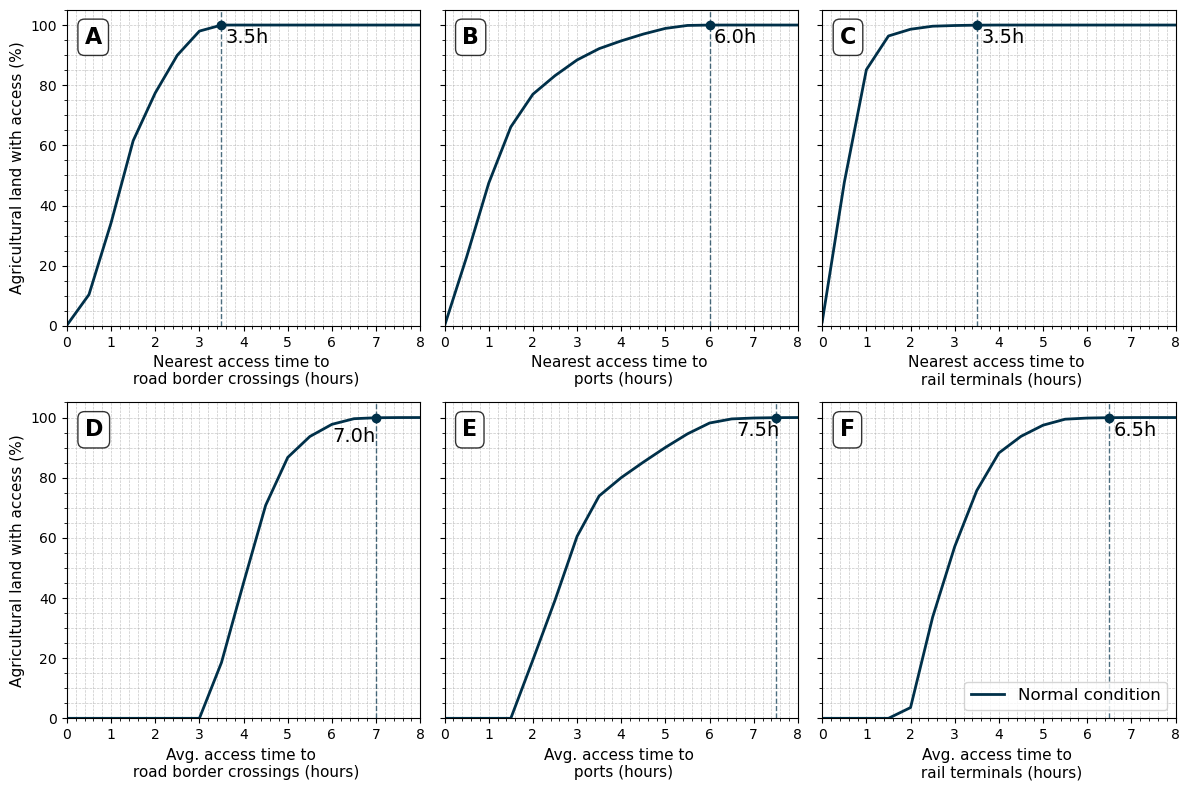

In [23]:
# =============================================================================
# VISUALIZATION: Baseline Accessibility Curves - Road, Port, Rail (3x2)
# Top row: Nearest sink | Bottom row: Average to all sinks
# =============================================================================

fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey='row')

# Define thresholds (shared)
thresholds = np.arange(0, 8.1, 0.5)  # Extended range based on your data (up to ~5.8h)

# Total agricultural land
total_ual = df_agri['UAL'].sum()

# Sink types configuration
# Top row: nearest | Bottom row: avg
# text_offset: (x_offset, y_position) for the threshold label
sink_configs = [
    # Top row - Nearest
    {'ax': axes[0, 0], 'col': 'nearest_access_road', 'label': 'A', 'title': 'road border crossings', 
     'metric': 'Nearest', 'show_ylabel': True, 'text_offset': (0.1, 94)},
    {'ax': axes[0, 1], 'col': 'nearest_access_port', 'label': 'B', 'title': 'ports', 
     'metric': 'Nearest', 'show_ylabel': False, 'text_offset': (0.1, 94)},
    {'ax': axes[0, 2], 'col': 'nearest_access_rail', 'label': 'C', 'title': 'rail terminals', 
     'metric': 'Nearest', 'show_ylabel': False, 'text_offset': (0.1, 94)},
    
    # Bottom row - Average
    {'ax': axes[1, 0], 'col': 'avg_access_road', 'label': 'D', 'title': 'road border crossings', 
     'metric': 'Avg.', 'show_ylabel': True, 'text_offset': (-1, 92)},
    {'ax': axes[1, 1], 'col': 'avg_access_port', 'label': 'E', 'title': 'ports', 
     'metric': 'Avg.', 'show_ylabel': False, 'text_offset': (-0.9, 94)},
    {'ax': axes[1, 2], 'col': 'avg_access_rail', 'label': 'F', 'title': 'rail terminals', 
     'metric': 'Avg.', 'show_ylabel': False, 'text_offset': (0.1, 94)},
]

for config in sink_configs:
    ax = config['ax']
    col = config['col']
    
    # Calculate percentage of UAL within each threshold
    percentage_ual = []
    for threshold in thresholds:
        ual_sum = df_agri.loc[df_agri[col] <= threshold, 'UAL'].sum()
        ual_percentage = (ual_sum / total_ual) * 100
        percentage_ual.append(ual_percentage)
    
    # Find 100% threshold
    threshold_100 = next((threshold for i, threshold in enumerate(thresholds) 
                          if percentage_ual[i] >= 99.9), None)
    
    # Plot
    ax.plot(thresholds, percentage_ual, linestyle='-', 
            color='#003049', linewidth=2, label='Normal condition')
    ax.set_xlabel(f'{config["metric"]} access time to \n {config["title"]} (hours)', fontsize=11)
    
    # Only show y-axis label on first column
    if config['show_ylabel']:
        ax.set_ylabel('Agricultural land with access (%)', fontsize=11)
    
    ax.minorticks_on()
    ax.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_aspect('auto', adjustable='box')
    ax.set_ylim(0, 105)
    ax.set_xlim(0, max(thresholds))
    
    # Add panel label
    ax.text(0.05, 0.95, config['label'], transform=ax.transAxes, fontsize=16,
            fontweight='bold', verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    if threshold_100 is not None:
        x_offset, y_pos = config['text_offset']
        ax.axvline(x=threshold_100, color='#003049', linestyle='--', linewidth=1, alpha=0.7)
        ax.plot(threshold_100, 100, 'o', color='#003049', markersize=6)
        ax.text(threshold_100 + x_offset, y_pos, f'{threshold_100:.1f}h', 
                color='black', ha='left', fontsize=14)

# Add shared legend to the last panel (bottom right)
axes[1, 2].legend(fontsize=12, loc='lower right')

# Final layout
plt.tight_layout()
plt.savefig(figure_path / 'baseline_accessibility_agri_road_port_rail_3x2.png', dpi=150, transparent=True)
plt.show()
plt.close()

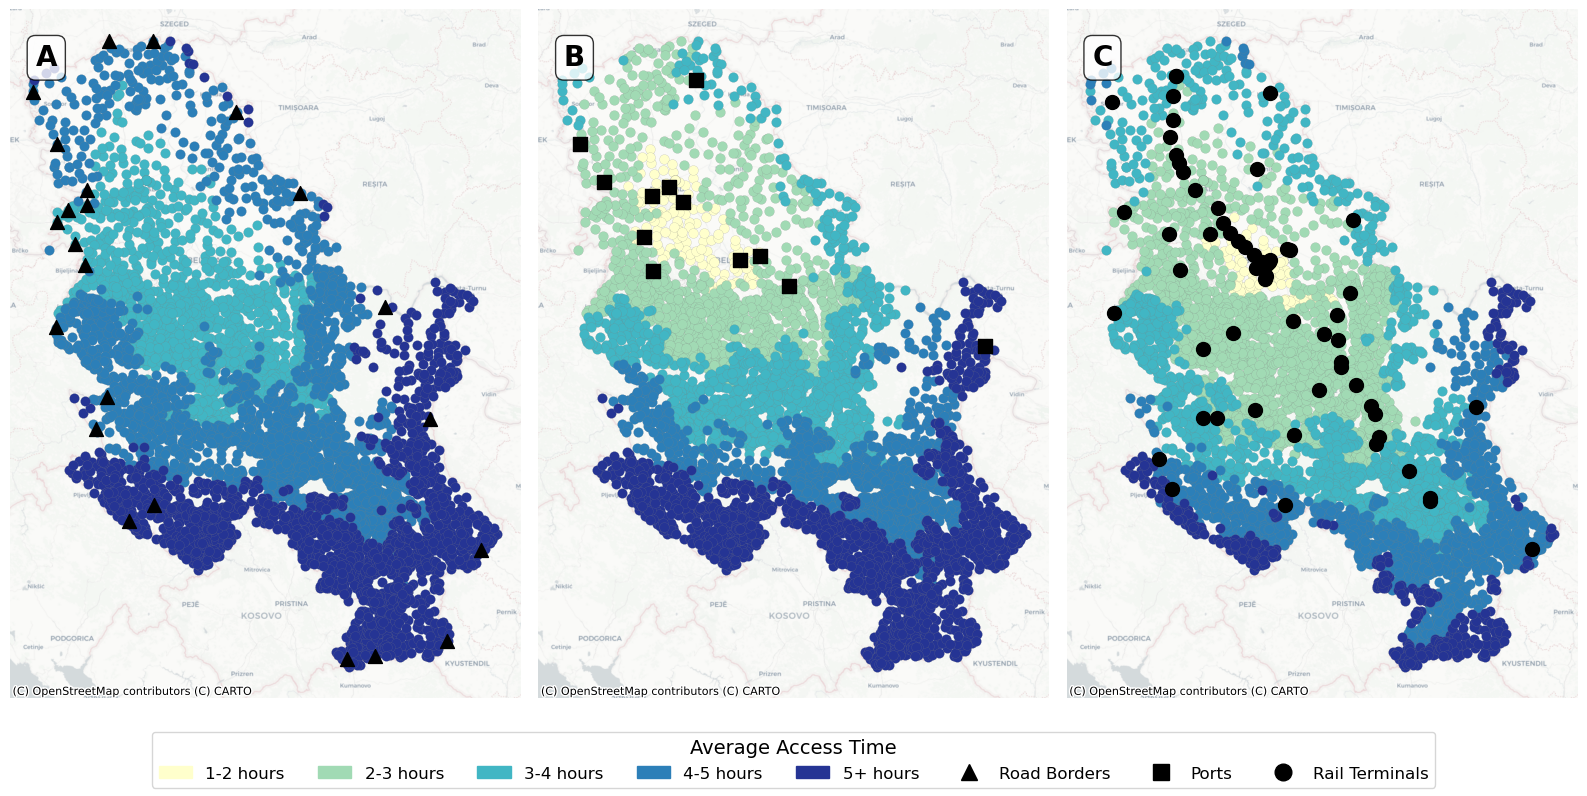

In [24]:
# =============================================================================
# 8. Visualization (3 panel map)
# =============================================================================
df_agri_plot = df_agri.to_crs(3857)
Sinks_plot = gpd.GeoDataFrame(Sinks, geometry='geometry', crs="EPSG:4326").to_crs(3857)

bins = [1, 2, 3, 4, 5, float('inf')]
labels_cat = ['1-2', '2-3', '3-4', '4-5', '5+']
colors = ['#ffffcc', '#a1dab4', '#41b6c4', '#2c7fb8', '#253494']
color_map = dict(zip(labels_cat, colors))

fig, axes = plt.subplots(1, 3, figsize=(16, 8))

for ax, col, title in zip(axes, 
                          ['avg_access_road', 'avg_access_port', 'avg_access_rail'],
                          ["A","B","C"]):
                          #['Road Border Crossings', 'Ports', 'Rail Terminals']):
    
    df_plot = df_agri_plot.copy()
    df_plot['category'] = pd.cut(df_plot[col], bins=bins, labels=labels_cat, right=False)
    df_plot['category'] = df_plot['category'].astype('object')
    
    for category, color in color_map.items():
        data = df_plot[df_plot['category'] == category]
        if not data.empty:
            data.plot(ax=ax, color=color, legend=False, linewidth=0.1, edgecolor='grey', markersize=50)
    
    # Plot relevant sinks
    if 'road' in col:
        sink_subset = Sinks_plot[Sinks_plot['type'] == 'road']
        marker = '^'
    elif 'port' in col:
        sink_subset = Sinks_plot[Sinks_plot['type'] == 'port']
        marker = 's'
    else:
        sink_subset = Sinks_plot[Sinks_plot['type'] == 'rail']
        marker = 'o'
    
    sink_subset.plot(ax=ax, color='black', markersize=100, marker=marker)
    
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

    # Add letter label
    ax.text(0.05, 0.95, title, transform=ax.transAxes, fontsize=20, 
            fontweight='bold', verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    ax.set_aspect('equal')
    ax.axis('off')
    #ax.set_title(title, fontsize=18, fontweight='bold')

# Shared legend
legend_patches = [mpatches.Patch(color=color, label=f'{label} hours') 
                  for label, color in zip(labels_cat, colors)]
legend_patches.extend([
    Line2D([0], [0], marker='^', color='black', lw=0, label='Road Borders', markersize=12),
    Line2D([0], [0], marker='s', color='black', lw=0, label='Ports', markersize=12),
    Line2D([0], [0], marker='o', color='black', lw=0, label='Rail Terminals', markersize=12),
])

fig.legend(handles=legend_patches, loc='lower center', ncol=8, fontsize=12, 
           title='Average Access Time', title_fontsize=14)

plt.tight_layout()
plt.subplots_adjust(bottom=0.12)
plt.savefig(figure_path / 'agriculture_access_by_type.png', dpi=200, bbox_inches='tight')
plt.show()